In [19]:
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
from utils.strings import TARGET, FEATURES, DATE
from utils.utilities import select_by_date

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Load data

In [2]:
inspecs= pd.read_csv('./data/inspecs_heat_scores.csv', parse_dates=[DATE])

In [3]:
inspecs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131979 entries, 0 to 131978
Data columns (total 26 columns):
camis                    131979 non-null int64
dba                      131979 non-null object
boro                     131979 non-null object
zipcode                  131979 non-null float64
cuisine_description      131979 non-null object
inspection_date          131979 non-null datetime64[ns]
action                   131979 non-null object
score                    126419 non-null float64
latitude                 131979 non-null float64
longitude                131979 non-null float64
grade                    126420 non-null object
violation_code           131979 non-null object
violation_description    131979 non-null object
critical_flag            131979 non-null object
inspection_type          131979 non-null object
critical                 131979 non-null int64
weekday                  131979 non-null int64
tmax                     131979 non-null int64
time_since_last  

## Look at the dates to find a good train/test split. 

Currently I am thinking I am going to train on 2017/2018 data and then predict the first 6 months of 2019

In [4]:
inspecs_for_train = select_by_date(inspecs, '2017-01-01', '2018-12-31')
inspecs_for_test = select_by_date(inspecs, '2019-01-01', '2019-5-31')

In [5]:
inspecs_for_train.shape

(71070, 26)

In [6]:
inspecs_for_test.shape

(21015, 26)

### Chose the columns we are going to work with

In [7]:
train_X = inspecs_for_train[FEATURES].values
train_Y = inspecs_for_train[TARGET].values.reshape(-1, 1)

test_X = inspecs_for_test[FEATURES].values
test_Y = inspecs_for_test[TARGET].values.reshape(-1, 1)

In [9]:
print(train_X.shape)
print(train_Y.shape)

print(test_X.shape)
print(test_Y.shape)

(21015, 8)
(21015, 1)


In [10]:
clf = LogisticRegression()
clf.fit(train_X, train_Y)
clf.score(test_X, test_Y)
y_pred = clf.predict(test_X)

/home/boada/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.metrics import classification_report
print(classification_report(test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2958
           1       0.86      1.00      0.92     18057

    accuracy                           0.86     21015
   macro avg       0.43      0.50      0.46     21015
weighted avg       0.74      0.86      0.79     21015



/home/boada/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
np.unique(y_pred)

array([1])

## So we are just predicting 1 everywhere

let's rebalance the classes

In [16]:
from sklearn.utils import resample

# make a new df and downsample

new_inspecs = inspecs[FEATURES + TARGET]

# Separate majority and minority classes
df_majority = new_inspecs[new_inspecs.critical==1]
df_minority = new_inspecs[new_inspecs.critical==0]

In [29]:
# Downsample Majority Class
df_majority_dsampled = resample(df_majority, 
                                 replace=False, # sample without replacement
                                 n_samples=len(df_minority)) # to match minority class
 
# Combine minority class with downsampled majority class
df_dsampled = pd.concat([df_minority, df_majority_dsampled])
 
# Display new class counts
print(df_dsampled.critical.value_counts())

1    17701
0    17701
Name: critical, dtype: int64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_dsampled.drop('critical',axis=1), 
                                                    df_dsampled['critical'], test_size=0.30)

logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [27]:
# after balancing the two target classes
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.54      0.45      0.49      5438
           1       0.51      0.60      0.55      5183

    accuracy                           0.52     10621
   macro avg       0.52      0.52      0.52     10621
weighted avg       0.52      0.52      0.52     10621



In [32]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

Accuracy: 0.5217964410130873
Precision: 0.5085413929040736
Recall: 0.5973374493536562


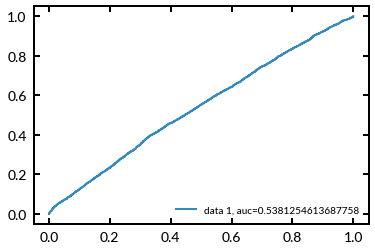

In [34]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)


# Do the same thing with date as the test split instead of randomly

In [38]:
# make a new df and downsample

new_inspecs = inspecs[FEATURES + TARGET + [DATE]]

# Separate majority and minority classes
df_majority = new_inspecs[new_inspecs.critical==1]
df_minority = new_inspecs[new_inspecs.critical==0]

# Downsample Majority Class
df_majority_dsampled = resample(df_majority, 
                                 replace=False, # sample without replacement
                                 n_samples=len(df_minority)) # to match minority class
 
# Combine minority class with downsampled majority class
df_dsampled = pd.concat([df_minority, df_majority_dsampled])
 
# Display new class counts
print(df_dsampled.critical.value_counts())

1    17701
0    17701
Name: critical, dtype: int64


In [44]:
df_dsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35402 entries, 1 to 125566
Data columns (total 10 columns):
weekday             35402 non-null int64
past_critical       35402 non-null float64
time_since_last     35402 non-null float64
tmax                35402 non-null int64
nypd_heat_score     35402 non-null float64
dsny_heat_score     35402 non-null float64
dep_heat_score      35402 non-null float64
dohmh_heat_score    35402 non-null float64
critical            35402 non-null int64
inspection_date     35402 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 3.0 MB


In [52]:
X_train = select_by_date(df_dsampled, '2017-01-01', '2018-12-31')
X_test = select_by_date(df_dsampled, '2019-01-01', '2019-02-28')

In [65]:
X_train.shape

(19484, 10)

In [64]:
X_test.shape

(1959, 10)

In [56]:
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train[FEATURES], X_train[TARGET])
predictions = logmodel.predict(X_test[FEATURES])

/home/boada/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
# after balancing the two target classes
print(classification_report(X_test[TARGET],predictions))

              precision    recall  f1-score   support

           0       0.51      0.94      0.66      1004
           1       0.43      0.05      0.08       955

    accuracy                           0.51      1959
   macro avg       0.47      0.49      0.37      1959
weighted avg       0.47      0.51      0.38      1959



In [63]:
logmodel.predict_proba(X_test[FEATURES][:20])

array([[0.5226951 , 0.4773049 ],
       [0.61226316, 0.38773684],
       [0.5308088 , 0.4691912 ],
       [0.53157318, 0.46842682],
       [0.5313026 , 0.4686974 ],
       [0.56153707, 0.43846293],
       [0.56747599, 0.43252401],
       [0.59293333, 0.40706667],
       [0.57528938, 0.42471062],
       [0.57527318, 0.42472682],
       [0.5152678 , 0.4847322 ],
       [0.56164825, 0.43835175],
       [0.54549614, 0.45450386],
       [0.5414472 , 0.4585528 ],
       [0.56023891, 0.43976109],
       [0.49953666, 0.50046334],
       [0.55103643, 0.44896357],
       [0.58951162, 0.41048838],
       [0.5398703 , 0.4601297 ],
       [0.53586173, 0.46413827]])

In [59]:
X_test[TARGET][:20]

,critical
139,0
147,0
200,0
427,0
686,0
815,0
893,0
938,0
1077,0
1221,0


# Look at decision trees

In [73]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train[FEATURES], X_train[TARGET])
clf.feature_importances_  

# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(X)
# X_new.shape 

/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


array([0.05224572, 0.00831976, 0.16762254, 0.14252225, 0.13289581,
       0.16452664, 0.16674541, 0.16512187])

In [75]:
for f, i in zip(FEATURES, clf.feature_importances_):
    print(f, i)

weekday 0.05224572066054112
past_critical 0.008319756904574448
time_since_last 0.16762253818808923
tmax 0.14252224598981347
nypd_heat_score 0.1328958128540906
dsny_heat_score 0.16452663710107554
dep_heat_score 0.16674541491444514
dohmh_heat_score 0.16512187338737053


In [76]:
predictions = clf.predict(X_test[FEATURES])

In [77]:
# after balancing the two target classes
print(classification_report(X_test[TARGET],predictions))

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1004
           1       0.54      0.35      0.42       955

    accuracy                           0.53      1959
   macro avg       0.54      0.53      0.52      1959
weighted avg       0.54      0.53      0.52      1959



# Try to use the silly TPOT

In [79]:
from tpot import TPOTClassifier

In [80]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40)
tpot.fit(X_train[FEATURES], X_train[TARGET])

/home/boada/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



2.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=8, min_samples_leaf=14, min_samples_split=10)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=100,
               max_eval_time_mins=0.04, max_time_mins=2, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=40,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [82]:
tpot.score(X_test[FEATURES], X_test[TARGET])

/home/boada/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5405819295558959

In [83]:
predictions = tpot.predict(X_test[FEATURES])

In [84]:
# after balancing the two target classes
print(classification_report(X_test[TARGET], predictions))

              precision    recall  f1-score   support

           0       0.54      0.79      0.64      1004
           1       0.56      0.28      0.37       955

    accuracy                           0.54      1959
   macro avg       0.55      0.53      0.50      1959
weighted avg       0.55      0.54      0.51      1959



# Let's preprocess some of the data

In [85]:
from sklearn import preprocessing

In [86]:
X_scaled = preprocessing.scale(X_train[FEATURES])

In [87]:
X_scaled

array([[ 1.37059444,  0.70517513,  1.64473157, ..., -0.0921906 ,
        -0.4731375 ,  0.11216369],
       [-0.05194715, -1.41808745, -0.86976922, ..., -0.01532828,
         0.22616592,  2.03468532],
       [ 0.65932364, -1.41808745,  1.59556536, ..., -0.32122538,
        -0.47024651,  2.54722035],
       ...,
       [ 1.37059444,  0.70517513,  0.42962365, ..., -0.99192642,
        -0.61736148, -0.80981242],
       [-0.05194715,  0.70517513, -0.70822308, ...,  0.57779186,
        -0.23572626, -0.77062066],
       [-0.76321795, -1.41808745, -0.86976922, ..., -0.66912596,
         0.34278311,  0.46860801]])

In [88]:
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_scaled, X_train[TARGET])

/home/boada/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
X_scaled_test = preprocessing.scale(X_test[FEATURES])

In [90]:
predictions = logmodel.predict(X_scaled_test)

In [91]:
# after balancing the two target classes
print(classification_report(X_test[TARGET],predictions))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59      1004
           1       0.50      0.35      0.41       955

    accuracy                           0.51      1959
   macro avg       0.51      0.51      0.50      1959
weighted avg       0.51      0.51      0.50      1959

